- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2025  
- **conda environment**: [mri conda environment](../mri_environment.yml).

# Brain Imaging Data Organisation

A brain imaging study typically involves multiple imaging protocols and subjects, resulting in complex datasets with numerous files in various formats, ranging from simple text files to multidimensional imaging data. These files can be organized in many ways, and without a consistent approach across projects and research groups, can arise in wasted time rearranging data or rewriting scripts to match specific file formats and structures, potentially introducing errors. Adopting a common standard for data organisation provides numerous advantages: it improves understanding of the data, even for those not directly involved in the project, reduces errors, enhances compatibility with analysis software, and facilitates the development of automated tools. In essence, it helps **make data FAIR** (Findable, Accessible, Interoperable, and Reusable).

The [Brain Imaging Data Structure (BIDS)](https://bids.neuroimaging.io/), developed since 2015, is a community-driven standard for organising data and metadata across various neuroscience modalities (MRI, MEG, EEG, PET). Converting your project's data into BIDS format enables easier sharing, reuse, and application of automated pipelines and quality assurance protocols, such as [BIDS Apps](https://bids-apps.neuroimaging.io/) or your/your group's own pipelines.

Converting raw data into the BIDS format may initially appear challenging. While there are various conversion tools available (see a list [here](https://bids.neuroimaging.io/benefits#converters)), the range of options can make it hard to decide which tool to use. For the MRI data conversion, we have chosen [HeuDiConv](https://joss.theoj.org/papers/10.21105/joss.05839) which in fact predates the BIDS format and is a flexible, general-purpose converter for organising MRI data into structured directory layouts. 

For the MEG/EEG data conversion to BIDS we are using [MNE-BIDS](https://mne.tools/mne-bids/stable/index.html), and that will be covered later in the course. 

In this tutorial, we will walk you through the process of converting fMRI data into BIDS format using HeuDiConv and show you how to interact with the resulting BIDS dataset using [PyBIDS](https://bids-standard.github.io/pybids/).

Here are two recommended short videos to help you better understand the basics of fMRI terminology and data structure.

In [ ]:
from IPython.display import display, HTML

display(HTML('''
<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3>fMRI Data Structure & Terminology (7 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/OuRdQJMU5ro" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3>Brain imaging data structure (11 min)</h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/5H6XaJLp2V8" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>
'''))

**Table of contents**  
1. Creating a project directory   
2. Raw MRI data  
3. Converting raw MRI DICOM series to BIDS using HeuDiConv    
3.1. Step 1: Discovering your scans   
3.2. Step 2: Creating a heuristic file    
3.3. Step 3: Converting the data  
3.4. After the conversion 'To Do' - additional information to check and add  
3.5. Validate BIDS structure   
1. Querying BIDS dataset with PyBIDS  
4.1. The `BIDSLayout`   
4.2. Filtering files by entities   
4.3. Filtering files by metadata   
4.4. Finding metadata values    
4.5. The `BIDSFile`    
4.6. `return_type` values   
4.7. Report generation   
4.8. More information   

------------

## Creating a project directory

There is no universally agreed standard, but here is a suggested folder structure for your brain imaging project.

```bash
# ======================================================================
# Suggested directory structure for a brain imaging project
# ======================================================================

# project_name                     
#    └── code/
#        └── task/           # Experimental task code (e.g., stimulus presentation)
#        └── preprocessing/  # Preprocessing scripts (e.g., BIDS conversion, MRIQC, fMRIPrep)
#        └── analysis/       # Analysis scripts and notebooks (statistical models, ROI analysis, etc.)
#        └── utils/          # (optional) Common functions or utilities used across tasks and analyses
#    └── config/             # (optional) pipeline configs, environment files
#    └── data/               # BIDS data and derivatives
#    └── documents/          # Protocols, reports, and other documentation
#    └── results/            # Analysis results, figures, and summary outputs
#    └── scratch/            # Temporary working files, intermediate analysis outputs (can safely delete)
#    └── logs/               # Log files, error reports, processing history
#    └── README.md           # Project overview and instructions

```

You can create the folder structure manually or use a simple `command-line` command like this:

```bash
mkdir -p My_fMRI_Project/{code/{task,preprocessing,analysis,utils},config,data,documents,results,scratch,logs} && touch My_fMRI_Project/README.md

```
We will create this folder structure for an example fMRI study that we will be working on primarily during the workshop **'06_fMRI'**, but also now. Our example project is called **'FaceRecognition'** and we will need it inside the COGNESTIC's 06_fMRI directory.  

We can run command-line commands directly within the notebook by adding an `'!'` sign at the beginning:

In [ ]:
# print working directory
!pwd

✅ Let's display the current content of the '06_fMRI' module.

In [ ]:
# list the content of the COGNESTIC/06_fMRI directory
!ls ../06_fMRI/


We can see that there already is the project folder 'FaceRecognition'. That is because we have preloaded some preprocessed data and results there already for later use, so that we don't need to spend a lot of time during the workshops to create this data. 

In [ ]:
# use the tree command to display the directory structure two levels deep
! tree ../06_fMRI/FaceRecognition/ -L 2

✅ Let's complete the recommended folder structure for our example 'FaceRecognition' project! You can run several command lines inside the notebook by adding `%%bash` at the beginning (by default the code cells are Python script cells).


In [ ]:
%%bash

# change the directory to where you want to create the project
cd ../06_fMRI

# define the project name
PROJECT_NAME="FaceRecognition"

# create the project directory and subdirectories
mkdir -p $PROJECT_NAME/{code/{task,preprocessing,analysis,utils},config,data,documents,results,scratch,logs} && touch $PROJECT_NAME/README.md

# print the directory structure, two levels deep
tree $PROJECT_NAME -L 2

We are now ready to carry on with our FaceRecognition fMRI project. 

For the present project, the data have been already collected. We just need to get that raw data and prepare for analysis. 



## Raw MRI data

Typically, all raw MRI data, whether it is anatomical, functional, diffusion etc., will be in a DICOM format. 

`DICOM` files are the raw imaging files generated by the MRI scanner, stored on an MRI data server. Here, at the CBU, each imaging project is assigned a unique code. By knowing the project's code, we can locate the raw DICOM files on our server. **Usually, there is no need to copy these data locally!** 

However, for this tutorial, we have copied one subject's DICOM data from our server to the `mridata` directory (and we removed two dummy scans to comply with [OpenNeuro version](https://openneuro.org/datasets/ds000117/versions/1.1.0) of this dataset).

In [ ]:
! tree ../06_fMRI/mridata/ -L 3

Each `Series###` folder contains DICOM files of the particular scan. The name of the folder is the same as what a radiographer named the scan in the MRI console. Usually, the name is very indicative of what type of scan it is. In the example above, we acquired a T1w anatomical/structural scan (**MPRAGE**), nine functional scans (**BOLD**), and two **field maps**. The *Series_001_CBU_Localiser* scan is a positional scan for the MRI and can be ignored.

Each of these folders contains DICOM (`.dcm`) files, typically, one file per slice for structural scans or one file per volume for functional scans. These files contain a header with the metadata (e.g., acquisition parameters) and the actual image itself. DICOM is a standard format for any medical image, not just the brain. To work with the brain images, we **need to convert the DICOM files to NIfTI format** which is a cross-platform and cross-software standard for brain images. Along with having the files in NIfTI format, we need to **name and organise them according to BIDS** standard. For that, we will use HeuDiConv.

## Converting raw MRI DICOM series to BIDS using HeuDiConv

HeudiConv is a Python-based comand-line tool. To use it, you would either install *heudiconv* and *dcm2niix* packages locally (`pip install heudiconv dcm2niix`) or use Docker (or Apptainer/Singularity) container image (`docker pull nipy/heudiconv`).

Here we have *heudiconv* (and the required *dcm2niix*, for dicom to nifti conversion) included in the `mri` conda environment that we are using for this workshop. 

HeuDiConv does the following:

- converts DICOM (.dcm) files to NIfTI format (`.nii` or `.nii.gz`);
- generates their corresponding metadata files (`.json`);
- renames the files and organises them in folders following BIDS specification;
- generates several other `.json` and `.tsv` files required for BIDS datasets.

The final result of DICOM Series being converted into BIDS for our example subject above would be this:

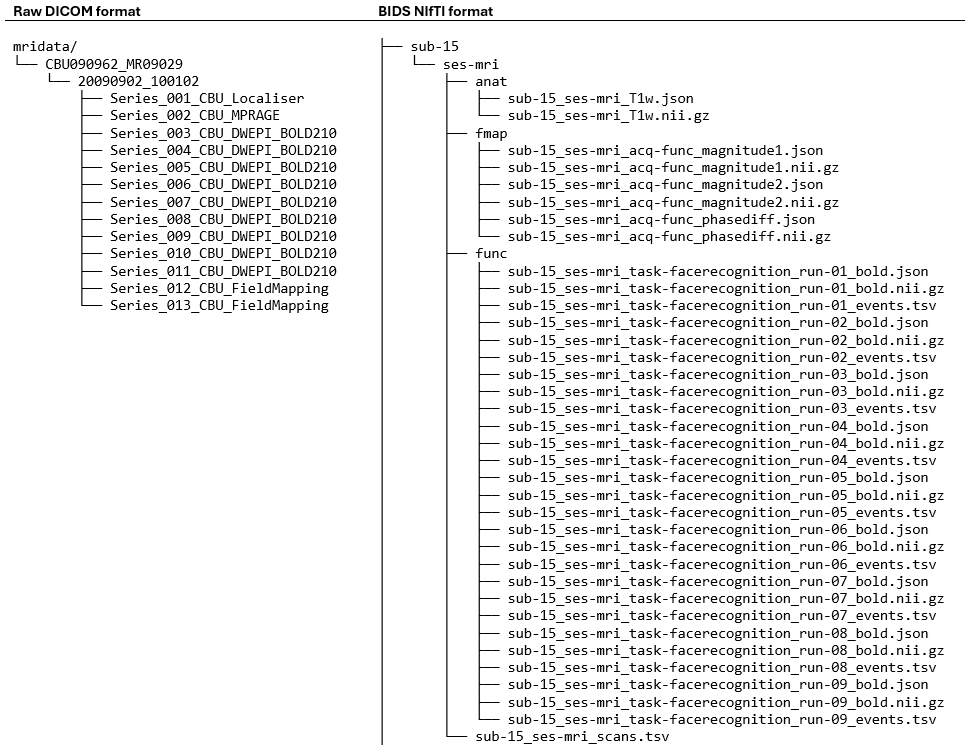

HeuDiConv needs information on how to translate your specific DICOMs into BIDS. This information is provided in a [heuristic file](https://heudiconv.readthedocs.io/en/latest/heuristics.html) that the user creates. To create the heuristic file, you need to know what scans you have, which ones you want to convert (you don't have to convert all scans, only the ones you need for your project), and how to uniquely identify each scan based on its metadata.

As such, **converting DICOM data to BIDS using HeuDiConv involves 3 main steps**:

 1. Discovering what DICOM series (scans) there are in your data
 2. Creating a heuristic file specifying how to translate the DICOMs into BIDS
 3. Converting the data

### Step 1: Discovering your scans

First, you need to know what scans there are in your MRI data and how to uniquely identify them using their metadata. While you could manually check the metadata of each DICOM file, this is not very convenient. Instead, you can 'ask' HeuDiConv to perform the scan discovery for you. By running HeuDiConv without specifying NIfTI conversion or a heuristic file, it will generate a DICOM info table that lists all scans and their metadata. It will look something like this:

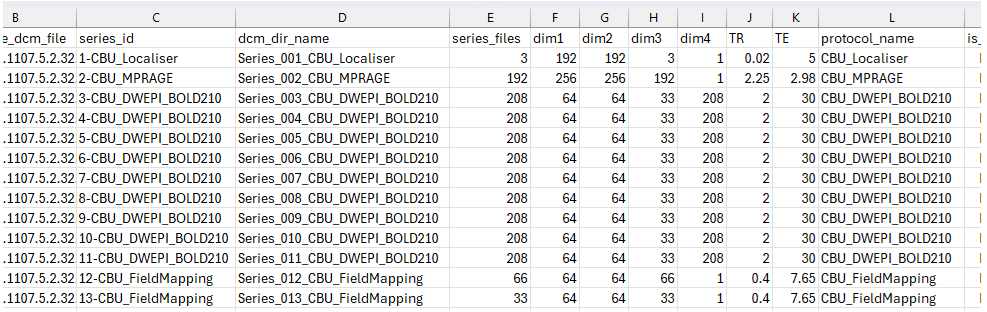

The column names are metadata fields and rows contain their corresponding values. To generate such a table, you would run the following command in the terminal:

`heudiconv --files ../mridata/CBU090962_MR09029/*/*/*.dcm --outdir ../FaceRecognition/scratch/dicom_discovery --heuristic convertall --subjects '15' --converter none --bids`

However, **command lines are error-prone and not easily reproducible**. Instead, we recommend writing a simple bash script like this [COGNESTIC/06_fMRI/code-examples/step01_dicom_discover.sh](../06_fMRI/code-examples/step01_dicom_discover.sh) 

**Example bash script:**

```bash
#!/bin/bash

# ============================================================
# This script is used to discover DICOM files using HeuDiConv.
#
# Usage: 
#   1. Activate the conda environment that contains heudiconv and dcm2niix.
#       conda ativate mri 
#   2. cd to the directory where this script is located
#   3. Run the script:
#       ./step01_dicom_discover.sh
#
# ============================================================

# ------------------------------------------------------------
# Define your paths
# ------------------------------------------------------------

# Path to the raw DICOM files
DICOM_PATH='../mridata/CBU090962_MR09029' # define either full path or relative to the script

# Location of the output data (it will be created if it doesn't exist)
OUTPUT_PATH='../FaceRecognition/scratch/dicom_discovery'

# Subject ID
SUBJECT_ID='15'

# ------------------------------------------------------------
# Run the heudiconv
# ------------------------------------------------------------
heudiconv \
--files "${DICOM_PATH}" \
--outdir "${OUTPUT_PATH}" \
--heuristic convertall \
--subjects "${SUBJECT_ID}" \
--converter none \
--bids
# ------------------------------------------------------------

# HeudiConv parameters:
# --files: Files or directories containing files to process
# --outdir: Output directory
# --heuristic: Name of a known heuristic or path to the Python script containing heuristic
# --subjects: Subject ID
# --converter : dicom to nii converter (dcm2niix or none)
# --bids: Flag for output into BIDS structure
#
# For a full list of parameters, see: https://heudiconv.readthedocs.io/en/latest/usage.html

```

✅ Let's run this script to discover which DICOMs our example subject has.

Normally, we would execute bash scripts from the terminal. However, we can also run command-line commands directly within the notebook by adding an '!' sign at the beginning. **After running it, it's a good idea to comment it out to avoid accidentally running it again when it's not needed.**

In [ ]:
#!../06_fMRI/code-examples/step01_dicom_discover.sh

In [ ]:
# list the content of the scratch directory, including hidden files (-a option)
!tree -a ../06_fMRI/FaceRecognition/scratch

After running the script, the table that we are interested in will be located at *`OUTPUT_PATH/.heudiconv/[subject ID]/info/dicominfo.tsv`*. The .heudiconv directory is a hidden directory and you might not be able to see it in your file system unless you copy it to an unhidden directory. 

In [ ]:
# ! cp ../06_fMRI/FaceRecognition/scratch/dicom_discovery/.heudiconv/15/info/dicominfo.tsv ../06_fMRI/FaceRecognition/scratch/dicom_discovery/dicominfo.tsv

Now, you can open the [`COGNESTIC/06_fMRI/FaceRecognition/scratch/dicom_discovery/dicominfo.tsv`](../06_fMRI/FaceRecognition/scratch/dicom_discovery/dicominfo.tsv) file and keep it open for the next step - creating a heuristic file. 

### Step 2: Creating a heuristic file

The heuristic file must be a `Python` file. You can create and edit Python files in any text editor. You can name the file anything you want. For example, `bids_heuristic.py` like we have named our file which is available here: [COGNESTIC/06_fMRI/code-examples/bids_heuristic.py](../06_fMRI/code-examples/bids_heuristic.py).

We need to specify the conversion template for each DICOM series. The template can be anything you want. In this particular case, we want it to be in BIDS format. Therefore, for each of our scan types, we need to consult BIDS specification. A good starting point is to look at the BIDS starter kit [folders](https://bids-standard.github.io/bids-starter-kit/folders_and_files/folders.html) and [filenames](https://bids-standard.github.io/bids-starter-kit/folders_and_files/files.html). (See the full BIDS specification for MRI [here](https://bids-specification.readthedocs.io/en/stable/modality-specific-files/magnetic-resonance-imaging-data.html).)

Following these guidelines, we define the template (folder structure and filenames) for our anatomical, fieldmap, and functional scans. We don't need to worry about the BIDS-required metadata, HeuDiConv will generate the required metadata for us.

```python
    # The structural/anatomical scan
    anat = create_key('sub-{subject}/ses-mri/anat/sub-{subject}_ses-mri_T1w')
    
    # The fieldmap scans
    fmap_mag = create_key('sub-{subject}/ses-mri/fmap/sub-{subject}_ses-mri_acq-func_magnitude')
    fmap_phase = create_key('sub-{subject}/ses-mri/fmap/sub-{subject}_ses-mri_acq-func_phasediff')
    
    # The functional scans
    # You need to specify the task name in the filename. It must be a single string of letters and/or numbers WITHOUT spaces, underscores, or dashes!
    func_task = create_key('sub-{subject}/ses-mri/func/sub-{subject}_ses-mri_task-facerecognition_run-{item:02d}_bold')
```

A couple of important points to note:
- If you only have a single session, you can omit the session hierarchy. Here we specify it to comply with the original [OpenNeuro dataset](https://openneuro.org/datasets/ds000117/versions/1.1.0) which had two sessions - MRI and MEG.  
- For the fielmaps, we add a key-value pair `acq-func` to specify that these fieldmaps are intended for the functional images - to correct the functional images for susceptibility distortions. You will see how this key-value is relevant later.
- For the functional scans, you have to specify the task name. In our case, the task was *Face Recognition*. The task name must be a **single string** of letters and/or numbers without spaces, underscores, or dashes!
- In this example project, we had multiple functional scans with identical parameters and task names. They correspond to multiple runs of our task. Therefore, we add a `run` key and its value will be added automatically as a 2-digit integer (*run-01*, *run-02* etc.).

Next, we create a dictionary `info` with our template names as keys and empty lists for their values. The values will be filled in in the next step.

```python
    info = {
        anat: [],
        fmap_mag: [],
        fmap_phase: [],
        func_task: []
        }
```
A `for loop` loops through all our DICOM series that are found in the `RAW_PATH` that we specify in our HeuDiConv parameters. Here we need to specify the criteria for associating DICOM series with their respective outputs. Now you need to look at the *dicominfo.tsv* table that we generated in the previous step.

- We only have one DICOM series with *MPRAGE* in its protocol name. Therefore, for the anatomical scan, we don't need to specify any additional criteria.

- We have two fieldmaps. One of them should be a *magnitude* image and the other one a *phase* image. Both have *FieldMapping* in their protocol name therefore we need to define additional criteria to distinguish between them. They differ in the `dim3` parameter. Typically, the *magnitude* image has twice as many slices (higher `dim3`) as the *phasedif* image.

- Our 9 functional scans are the only ones with more than one volume (`dim4`). They all are different runs of the same task, therefore we don't need any other distinguishing criteria for them, just the `dim4`. We specify here `dim4 > 100` because it could happen that not all participants and not all runs had exactly 208 volumes collected. In addition, sometimes it happens that a run is cancelled due to some problem, and we want to discard any run with less than 100 volumes.

```python
# Loop through all the DICOM series and assign them to the appropriate conversion key.
    for s in seqinfo:
        # Uniquelly identify each series
        
        # Structural
        if "MPRAGE" in s.series_id:
            info[anat].append(s.series_id)
            
        # Field map Magnitude (the fieldmap with the largest dim3 is the magnitude, the other is the phase)
        if 'FieldMapping' in s.series_id and s.series_files == 66:
            info[fmap_mag].append(s.series_id)
            
        # Field map PhaseDiff
        if 'FieldMapping' in s.series_id and s.series_files == 33:
            info[fmap_phase].append(s.series_id)

        # Functional Bold
        if s.dim4 > 100:
           info[func_task].append(s.series_id)
            
    # Return the dictionary
    return info
```
Finally, we add `POPULATE_INTENDED_FOR_OPTS` dictionary to our heuristic file. This will automatically add an `IntendedFor` field in the fieldmap .json files telling for which images the fieldmaps should be used to correct for susceptibility distortion. Typically, these are the functional images. There are several options how you can specify for which images the fieldmaps are intended for. See full information [here](https://heudiconv.readthedocs.io/en/latest/heuristics.html#populate-intended-for-opts). In our example, we specify to look for a `modality acquisition label`. It checks for what modality (e.g., *anat*, *func*, *dwi*) each fieldmap is intended by checking the `acq-` label in the fieldmap filename and finding corresponding modalities. For example, `acq-func` will be matched with the `func` modality. That's why when defining the template for the `fmap_mag` and `fmap_phase` we added `acq-func` in their filenames.

```python
POPULATE_INTENDED_FOR_OPTS = {
    'matching_parameters': ['ModalityAcquisitionLabel'],
    'criterion': 'Closest'
}
```

Other, more advanced functions can be added to the heuristic file as well, such as input file filtering. For full information, see the [documentation](https://heudiconv.readthedocs.io/en/latest/heuristics.html).

You can see and edit our example heuristic file here: [COGNESTIC/06_fMRI/code-examples/bids_heuristic.py](../06_fMRI/code-examples/bids_heuristic.py).

### Step 3: Converting the data

Once our heuristic file is created, we are ready to convert our raw DICOM data to BIDS.

To do that, we need to make three changes in our *COGNESTIC/06_fMRI/code-examples/step01_dicom_discover.sh* bash script that we wrote in the first step. We named the edited script [COGNESTIC/06_fMRI/code-examples/step02_dicom_to_bids.sh](../06_fMRI/code-examples/step02_dicom_to_bids.sh).

- We need to change the output path because we don't want to put this result in the *scratch* directory but in the final *data* directory
- We need to change the `--heuristic` parameter specifying the path to our newly created heuristic file
- We need to change the `--converter` parameter to `dcm2niix` because now we want the DICOM files to be converted to NIfTI format.

```bash
# Path to the raw DICOM files
DICOM_PATH='../mridata/CBU090962_MR09029' # define either full path or relative to the script

# Location of the output data (it will be created if it doesn't exist)
OUTPUT_PATH='../FaceRecognition/data'

# Subject ID
SUBJECT_ID='15'

# Heuristic file for BIDS conversion
HEURISTIC_FILE='bids_heuristic.py'

# ------------------------------------------------------------
# Run the heudiconv
# ------------------------------------------------------------
heudiconv \
    --files "${DICOM_PATH}" \
    --outdir "${OUTPUT_PATH}" \
    --heuristic "$HEURISTIC_FILE" \
    --subjects "${SUBJECT_ID}" \
    --converter dcm2niix \
    --bids
```

Once these changes are saved, you can run the script from the terminal:

`../06_fMRI/code-examples/step02_dicom_to_bids.sh`

✅ Let's run the script to convert our example subject's raw DICOM data to BIDS. We will need the converted data for our next steps!

In [ ]:
#!../06_fMRI/code-examples/step02_dicom_to_bids.sh

💡 **A note on Bash vs Python** 

The example bash script is intentionally simple. We're just setting up some basic variables for the `heudiconv` command. However, scripts can become more complex if you'd like to include extra checks or define subjects and their DICOM paths in a more flexible way. Bash scripts can be somewhat unintuitive when you're first learning them. If you're more comfortable with Python, you can define variables, implement helpful checks, and use Python's built-in tools (like the `subprocess` module) to run bash commands directly from your Python scripts.

Here is an example of the `step02_dicom_to_bids` script written in Python and using `subprocess`: [COGNESTIC/06_fMRI/code-examples/step02_dicom_to_bids.py](../06_fMRI/code-examples/step02_dicom_to_bids.py)

### After the conversion 'To Do' - additional information to check and add

Once you have converted the DICOMs to BIDS, there are some details you'll need to fill in yourself to ensure the dataset is fully BIDS-compliant. HeuDiConv marks any 'missing' information with `'To Do'` placeholders.

#### Events - for functional tasks

For functional tasks, you need to provide at least minimal details of *onset*, *duration*, and *trial type* for each trial in that run. In addition, you can add other details that are specific to your experiment. This data should come from the outputs of your experimental script, so make sure your task is programmed in a way that allows you to easily retrieve the necessary trial and timing information. See [BIDS specification on Task events](https://bids-specification.readthedocs.io/en/stable/modality-specific-files/task-events.html) for more information on how to format the events.tsv files. 

HeuDiConv generates the `events.tsv` template file for each functional run.

In [ ]:
# List files in the BIDS func directory and sort them by extension
import os

root = "../06_fMRI/FaceRecognition/data/sub-15/ses-mri/func/"
files_by_ext = {}

for foldername, _, filenames in os.walk(root):
    for filename in filenames:
        ext = os.path.splitext(filename)[1]
        if ext not in files_by_ext:
            files_by_ext[ext] = []
        relative_path = os.path.relpath(os.path.join(foldername, filename), root)
        files_by_ext[ext].append(relative_path)

# Print sorted results
for ext, files in sorted(files_by_ext.items()):
    print(ext)
    for file in sorted(files):
        print(f"  └── {file}")

The files are just a template that you need to fill with the actual data.

In [ ]:
import pandas as pd

events_file_empty = pd.read_csv('../06_fMRI/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_events.tsv', sep='\t', index_col=0)
events_file_empty


**For our example subject, we can retrieve the data from the OpenNeuro version of this dataset.**

✅ To do so, run the [COGNESTIC/06_fMRI/code-examples/step03_get_events.py](../06_fMRI/code-examples/step03_get_events.py) script!

In [ ]:
#!python ../06_fMRI/code-examples/step03_get_events.py


Alternatively, if the download doesn't work for some reason (e.g. due to Internet connection issues), we have also included these event files in the preloaded data (`COGNESTIC/06_fMRI/sub-15_task_files`). You just need to copy them to the BIDS directory. To do that, uncomment and run the cell below. 

In [ ]:
# # remove the existing events files
# !rm -f ../06_fMRI/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-*.tsv

# # copy the prepared events
# !cp -r ../06_fMRI/sub-15_task-files/* ../06_fMRI/FaceRecognition/data/sub-15/ses-mri/func

We can now check the content of the events files.

In [ ]:
events_file_filled = pd.read_csv('../06_fMRI/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_events.tsv', sep='\t', index_col=0)
events_file_filled

#### Dataset description

Each BIDS dataset must have a [Dataset description .json file](https://bids-specification.readthedocs.io/en/stable/modality-agnostic-files.html#dataset-description) - a brief description of the dataset. HeuDiConv generates a template file that you can than fill in with the information relevant to your dataset. 


```json
{
  "Acknowledgements": "TODO: whom you want to acknowledge",
  "Authors": [
    "TODO:",
    "First1 Last1",
    "First2 Last2",
    "..."
  ],
  "BIDSVersion": "1.8.0",
  "DatasetDOI": "TODO: eventually a DOI for the dataset",
  "Funding": [
    "TODO",
    "GRANT #1",
    "GRANT #2"
  ],
  "HowToAcknowledge": "TODO: describe how to acknowledge -- either cite a corresponding paper, or just in acknowledgement section",
  "License": "TODO: choose a license, e.g. PDDL (http://opendatacommons.org/licenses/pddl/)",
  "Name": "TODO: name of the dataset",
  "ReferencesAndLinks": [
    "TODO",
    "List of papers or websites"
  ]
}
```

See a complete description for this dataset here: https://openneuro.org/datasets/ds000117/versions/1.1.0/file-display/dataset_description.json

#### README

Each BIDS dataset should also have a [README text file](https://bids-specification.readthedocs.io/en/stable/modality-agnostic-files.html#readme).  
HeuDiConv generated template: *"TODO: Provide description for the dataset -- basic details about the study, possibly pointing to pre-registration (if public or embargoed)"*  
See an example for the OpenNeuro version of this dataset https://openneuro.org/datasets/ds000117/versions/1.1.0/file-display/README

#### CHANGES
[CHANGES text file](https://bids-specification.readthedocs.io/en/stable/modality-agnostic-files.html#readme) may contain information about the changes, updates and corrections of the dataset.  
HeuDiConv generates a template for CHANGES file.  
See an example for the OpenNeuro version of this dataset https://openneuro.org/datasets/ds000117/versions/1.1.0/file-display/CHANGES

#### Participants file

It is also recommended having a tabular [participants file](https://bids-specification.readthedocs.io/en/stable/modality-agnostic-files.html#participants-file) that contains information of participants such as participant ID, age and sex. 

HeuDiConv generates `participants.tsv` and `participants.json` files which you can then edit as needed. 

In [ ]:
pd.read_csv('../06_fMRI/FaceRecognition/data/participants.tsv', sep='\t', index_col=0)

### Validate BIDS structure

Once we have our BIDS dataset, we can use an [online BIDS validator](https://bids-standard.github.io/bids-validator/) to check if our dataset confirms with BIDS standard and what additional information we might need to include in your dataset's metadata. 

## Querying BIDS dataset with PyBIDS

`PyBids` is a Python module to help interact with datasets conforming BIDS. See the [documentation](https://bids-standard.github.io/pybids/) and [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7409983/) for more information.  
The material below is adapted from https://bids-standard.github.io/pybids/examples/pybids_tutorial.html

With PyBIDS, you can query any BIDS dataset regardless of modality (MRI, MEG, etc.).

### The `BIDSLayout`


`BIDSLayout` represents a BIDS project file tree and provides a variety of helpful methods for querying and manipulating BIDS files. 

In [ ]:
# Import the BIDSLayout class from the bids module
from bids import BIDSLayout

# Define the path to the BIDS directory
fmri_data_dir = '../06_fMRI/FaceRecognition/data'

# Initialize the layout
bids_layout = BIDSLayout(fmri_data_dir)

# Print the basic information about the layout
bids_layout

The `layout` now contains an index of all the files and metadata found in our BIDS dataset. 

The main method for querying `BIDSLayout` is `.get()`.

If we call `.get()` with no additional arguments, we get back a list of all the BIDS files in our dataset.

In [ ]:
all_files = bids_layout.get()

num_files = len(all_files)
print("There are {} files in the layout:".format(num_files))
all_files

By default,`BIDSLayout` only includes raw BIDS data. Derivatives (e.g., outputs from `fMRIPrep`, `MRIQC`, or custom preprocessing) are not included.

However, you can include them by setting `derivatives=True`. This will automatically include all recognised derivatives found in the BIDS `derivatives/` folder.

In [ ]:
# Include all pipelines found in the derivatives subdirectory
bids_layout_with_derivatives = BIDSLayout(fmri_data_dir, derivatives=True)

all_files = bids_layout_with_derivatives.get()
print("There are {} files in the layout:".format(len(all_files)))


You can also include just a specific derivative (or a list of specific derivatives):

In [ ]:
# Include only a specific derivative
bids_layout_with_fmriprep = BIDSLayout(fmri_data_dir, derivatives=fmri_data_dir + '/derivatives/fmriprep')

all_files = bids_layout_with_fmriprep.get()
print("There are {} files in the layout:".format(len(all_files)))

# Include a list of specific derivatives
bids_layout_with_fmriprep_mriqc = BIDSLayout(fmri_data_dir, derivatives=[fmri_data_dir + '/derivatives/fmriprep', fmri_data_dir + '/derivatives/mriqc'])

all_files = bids_layout_with_fmriprep_mriqc.get()
print("There are {} files in the layout:".format(len(all_files)))

You can also attach additional derivatives after layout creation:

In [ ]:
# Attach additional derivatives
bids_layout_with_derivatives.add_derivatives('../06_fMRI/FaceRecognition/results/first-level')

all_files = bids_layout_with_derivatives.get()
print("There are {} files in the layout:".format(len(all_files)))

### Filtering files by entities

We can pass BIDS-defined entities (key-value pairs within filenames) to the .get() method to filter which files we want to select from the `BIDSLayout`. This is very useful when a dataset contains multiple subjects, sessions, tasks, or imaging modalities.

Here are a few of the most common filename entities:

* `subject`: The subject label
* `session`: The session label
* `run`: The run index
* `task`: The task name
* `datatype`: The BIDS data type (e.g., 'anat', 'fmap', func')
* `suffix`: The part of a BIDS filename just before the extension (e.g., 'bold', 'events', 'T1w', etc.).
* `extension`: The filename extension

You can check which values exist for each entity in your dataset:

In [ ]:
# Get all subjects
print("Subject IDs:", bids_layout.get_subject())

# Get all sessions
print("Sessions:", bids_layout.get_session())

# Get all runs
print("Runs:", bids_layout.get_run())

# Get all tasks
print("Tasks:", bids_layout.get_task())

# Get all datatypes
print("Datatypes:", bids_layout.get_datatype())

# Get all suffixes
print("Suffixes:", bids_layout.get_suffix())

# Get all extensions
print("Extensions:", bids_layout.get_extension())

For example, we can **retrieve all BOLD run files for a specific subject**:

- from the layout without derivatives

In [ ]:
bids_layout.get(subject='15', suffix='bold', extension='nii.gz')

- from the layout with derivatives

In [ ]:
bids_layout_with_derivatives.get(subject='15', suffix='bold', extension='nii.gz')

Because we included derivatives in our layout, this query returns **both raw and preprocessed BOLD files**, for example, from the raw `func/` folder and from pipelines like `fMRIPrep`.

If you want to limit your query to **only the raw files**, or **only files from derivatives**, you can use the `scope` argument:

- **Only raw files**:

In [ ]:
bids_layout_with_derivatives.get(subject='15', suffix='bold', extension='nii.gz', scope='raw')


- **Only files from derivatives:**

In [ ]:
bids_layout_with_derivatives.get(subject='15', suffix='bold', extension='nii.gz', scope='derivatives')

We can filter the layout by any key that appears in a BIDS filename. However, **the entity names used in PyBIDS are not always exactly the same as how they appear in the filenames**. For example, filenames use `acq-`, but PyBIDS uses the keyword `acquisition`. 
To see all available **filename-based entities** in your dataset, use: 

In [ ]:
bids_layout_with_derivatives.get_entities(metadata=False)

For each of these we can retrieve all their values within our layout. 

In [ ]:
# Get all preprocessed spaces
bids_layout_with_derivatives.get_space()


**🧠 EXERCISE 1**

From the layout that includes all derivatives, retrieve sub-15 raw anatomical image.

In [ ]:
# sub-15 raw anatomical image


**🧠 EXERCISE 2**

From the layout that includes all derivatives, retrieve sub-15 event files.

In [ ]:
# sub-15 event files


**🧠 EXERCISE 3**

Within the layout that includes all derivatives, list suffixes of all fieldmap images. 

In [ ]:
# List suffixes of all fieldmap images


### Filtering files by metadata

Sometimes we want to search for files not just by their **filenames**, but also based on **metadata** stored in accompanying `.json` sidecar files.

In [ ]:
# List all metadata keys in the layout
bids_layout.get_entities(metadata=True)

For example, you might want to find all BOLD runs with a specific Repetition Time (TR) or Echo Time. This can be combined with any number of core BIDS entities (like subject, run, task, etc.).

In [ ]:
bids_layout.get(subject='15', RepetitionTime='2')

### Finding metadata values

You can also search for specific metadata values: 

In [ ]:
bids_layout.get_SpacingBetweenSlices(subject='15', suffix='bold')

In [ ]:
bids_layout.get_RepetitionTime(task='facerecognition')

For common metadata fields like Repetition Time (TR), PyBIDS provides dedicated helper functions.

For example `get_tr()` is a shortcut for calling `get_RepetitionTime()`

In [ ]:
bids_layout.get_tr(task='facerecognition')


💡 **Tip:** You can explore all available `get_...()` methods using tab completion in Jupyter after typing `bids_layout.get_`.

In [ ]:
#bids_layout.get

With a more bit programming, we can check a number of volumes per run for each participant.

In [ ]:
for sID in bids_layout.get_subjects(): # Loop through each subject
  
    # Initialize a list to store the number of volumes for each run
    volumes_per_run = []
    
    # Loop through each run for the specific subject
    for rID in bids_layout.get_runs(subject=sID):
      
        # Get the BOLD file for the specific subject and run
        [bold_file] = bids_layout.get(subject=sID, run=rID, extension='nii.gz', suffix='bold', scope='raw')
        
        # Get the metadata for the corresponding BOLD file
        metadata = bids_layout.get_metadata(bold_file.path)
        
        # Extract the number of volumes from the metadata
        num_volumes = metadata.get("dcmmeta_shape", [])[3]
        
        # Append the number of volumes to the list
        volumes_per_run.append(num_volumes)
        
    # Print the number of volumes per run for each subject
    print(f"Subject {sID}: Number of volumes per run: {volumes_per_run}")


### The `BIDSFile`

When you call `.get()` on a `BIDSLayout`, the default return value is a list of `BIDSFile` objects. A `BIDSFile` is a lightweight wrapper around a single file in the BIDS dataset. It gives you convenient access to useful attributes and methods, such as the file's path, associated metadata, and extracted entities (like subject, task, run, etc.).

Here are some of the most useful attributes and methods available in a `BIDSFile` object (⚠️ Note: Some methods only apply to specific types of files. For example, you can't call `.get_image()` on a text file, or `.get_df()` on a NIfTI file):

* `.path`: Full path to the file
* `.filename`: Just the filename (without a directory)
* `.dirname`: The directory the file is in
* `.get_entities()`: Returns a dictionary of BIDS entities (like subject, task, run)
* `.get_metadata()`: Returns a dictionary of associated metadata from sidecar `.json` files
* `.get_associations()`: Lists all files associated with this file (e.g., a `.nii.gz` file might be associated with its `.json` metadata file)
* `.get_image()`: Loads the file as a `nibabel` image (only for NIfTI or image files)
* `.get_df()`: Loads the file as a pandas DataFrame (only for TSV/CSV files)

In [ ]:
# Pick one BOLD file from the layout
bids_bold_file = bids_layout.get(suffix='bold', extension='nii.gz')[0]

print("Example BIDS file object: \n ", bids_bold_file)

print("Path: \n ", bids_bold_file.path)
print("Filename: \n ", bids_bold_file.filename)
print("Directory: \n ", bids_bold_file.dirname)
print("Entities: \n ", bids_bold_file.get_entities())

# Load metadata
metadata = bids_bold_file.get_metadata()
print("TR:", metadata.get('RepetitionTime'))

# Show associated files
print("Associated files:", *bids_bold_file.get_associations(), sep='\n ')

If the file is a NIfTI image (`.nii` or `.nii.gz`), PyBIDS will automatically treat it as `BIDSImageFile` and we can load its contents using the `.get_image()` method. This returns a `nibabel` image object, which gives access to both the image data and header information. This is equivalent to loading the file directly with nibabel (`nibabel.load(path_to_file.nii.gz)`)

In [ ]:
# Load it as a nibabel image (notice that we don't need to import nibabel explicitly, as PyBIDS handles it for us)
img = bids_bold_file.get_image()

# Inspect the image
print("Image shape:", img.shape)
print("Affine matrix:\n", img.affine)

%matplotlib inline
# Display the image using orthoview
img.orthoview()


In cases where a file has a `.tsv `or `.tsv.gz` extension, PyBIDS will automatically treat it as a `BIDSDataFile`. This allows you to easily load its contents as a pandas` DataFrame` using the `.get_df()` method.

In [ ]:
# Pick one events file from the layout
bids_events_file = bids_layout.get(suffix='events', extension='tsv')[0]

print("Example BIDS events file object: \n ", bids_events_file)

# Load the events file as a pandas DataFrame
bids_events_file.get_df()


### `return_type` values

By default, the `.get()` method returns a list of `BIDSFile` objects, as described above. However, you can control what kind of result you get by specifying the `return_type` argument.

Here are the possible options:

| `return_type`            | What it returns                                                   |
| ------------------------ | ----------------------------------------------------------------- |
| `'object'` (default)     | A list of `BIDSFile` objects                                      |
| `'filename'` or `'file'` | A list of full file paths as strings                              |
| `'dir'`                  | A list of directories for a specified `target` (subject, session) |
| `'id'`                   | A list of unique IDs for a specified `target` (subject, session)  |

In [ ]:
bids_bold_file = bids_layout.get(suffix='bold', extension='nii.gz')
print("Example BIDS objects:", *bids_bold_file, sep='\n ')

bids_bold_filename = bids_layout.get(suffix='bold', extension='nii.gz', return_type='filename')
print("\nExample BIDS filenames:", *bids_bold_filename, sep='\n ')

While we will typically work with either `BIDSFile` objects or plain filenames, PyBIDS also allows us to retrieve unique values for a specific entity using `return_type='id'`. This is useful when we want to know which values of a certain entity are present in the dataset, such as which subjects have fieldmaps available.

We can request this information by setting `return_type='id'`.  
When using this option, we also need to specify a target entity (or metadata keyword) called `target`. This combination tells the `BIDSLayout` to return the unique values for the specified target entity. 

In [ ]:
# Return the ids of subjects that have fieldmaps available
bids_layout.get(return_type='id', target='subject', datatype='fmap')

In [ ]:
# Return ids of tasks that have events files
bids_layout.get(return_type='id', target='task', suffix='events', extension='tsv')

In [ ]:
# Return ids of subjects that have first-level analysis effects
bids_layout_with_derivatives.get(return_type='id', target='subject', suffix='effect')

In [ ]:
# What first-level analysis effects are available in the derivatives?
bids_layout_with_derivatives.get(return_type='id', target='desc', suffix='effect')

### Report generation

PyBIDS also includes an experimental feature for generating a data acquisition section directly from a BIDS dataset. This functionality is still under development and should be used with caution. Currently, it supports **only MRI datatypes**: func, anat, fmap, and dwi. **The report can only be generated from layouts that do not include derivatives.** 

Despite its limitations, it can be a helpful starting point for writing the methods section of your publication.

In [ ]:
# import the BIDSReport function from the reports submodule
from bids.reports import BIDSReport

# Initialize a report for the dataset
report = BIDSReport(bids_layout)

# Method 'generate' returns a counter of unique descriptions across subjects
descriptions = report.generate()

# Get the most common description
common_description = descriptions.most_common()[0][0]

# Print the most common description
print(common_description)


### More information

In this tutorial, we covered only a subset of PyBIDS functionality to help you get started with exploring and querying BIDS datasets. For the full documentation and advanced usage, please refer to the official PyBIDS documentation: https://bids-standard.github.io/pybids/  
You can also explore the [GitHub repository](https://github.com/bids-standard/pybids) for examples, updates, and community discussions.